In [2]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


plt.style.use("mike")
import warnings
warnings.simplefilter("ignore")

warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey


from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps


In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [ ]:
ab.write_yaml("test_proc.yml")

In [2]:
ds = DataSet.from_yaml("test_proc.yml")


In [205]:
ds.to_hdf5_file("sgrb.h5")

In [74]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

shit
shit
shit
shit
shit


In [75]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [76]:
m = get_model("cpl_simple_chunked")

In [77]:
m.clean_model()

In [78]:
m.build_model()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jburgess/coding/projects/zusammen/zusammen/stan_models/cpl_simple_chunked


In [79]:
data = ds.to_stan_dict()

n_threads = 3
n_chains = 2

fit = m.model.sample(
    
       data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    #inits= {'alpha':-1.},
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    show_progress=True,)
    
    

INFO:cmdstanpy:sampling: ['/Users/jburgess/coding/projects/zusammen/zusammen/stan_models/cpl_simple_chunked', 'id=1', 'random', 'seed=1234', 'data', 'file=/var/folders/_0/x_8bb4nj2g1fwkn77r2wv5_40000gn/T/tmpk18149og/6krsz1jd.json', 'output', 'file=/var/folders/_0/x_8bb4nj2g1fwkn77r2wv5_40000gn/T/tmpk18149og/cpl_simple_chunked-20211114204319-1-mnnao1v6.csv', 'method=sample', 'num_samples=500', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=12', 'adapt', 'engaged=1']


chain 2 |          | 00:00 Status

chain 1 |          | 00:00 Status

INFO:cmdstanpy:sampling completed


In [41]:
 m.model.sample?

Signature:
m.model.sample(
    data: Union[Mapping[str, Any], str, NoneType] = None,
    chains: Union[int, NoneType] = None,
    parallel_chains: Union[int, NoneType] = None,
    threads_per_chain: Union[int, NoneType] = None,
    seed: Union[int, List[int], NoneType] = None,
    chain_ids: Union[int, List[int], NoneType] = None,
    inits: Union[Dict[str, float], float, str, List[str], NoneType] = None,
    iter_warmup: Union[int, NoneType] = None,
    iter_sampling: Union[int, NoneType] = None,
    save_warmup: bool = False,
    thin: Union[int, NoneType] = None,
    max_treedepth: Union[int, NoneType] = None,
    metric: Union[str, Dict[str, Any], List[str], List[Dict[str, Any]], NoneType] = None,
    step_size: Union[float, List[float], NoneType] = None,
    adapt_engaged: bool = True,
    adapt_delta: Union[float, NoneType] = None,
    adapt_init_phase: Union[int, NoneType] = None,
    adapt_metric_window: Union[int, NoneType] = None,
    adapt_step_size: Union[int, NoneType] = N

In [80]:
res = av.from_cmdstanpy(fit)

In [81]:
res.sample_stats.treedepth.max()

<xarray.DataArray 'treedepth' ()>
array(12)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu_raw'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_sigma'}>,
        <AxesSubplot:title={'center':'log_energy_flux_sigma'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_raw'}>,
        <AxesSubplot:title={'center':'log_energy_flux_raw'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'log_energy_flux'}>,
        <AxesSubplot:title={'center':'log_energy_flux'}>],
       [<AxesSubplot:title={'center':'log_energy_flux_mu'}>,
        <AxesSubplot:title={'center':'log_energy_flux_mu'}>],
       [<AxesSubplot:title={'center':'energy_flux'}>,
        <AxesSubplot:title={'cente

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
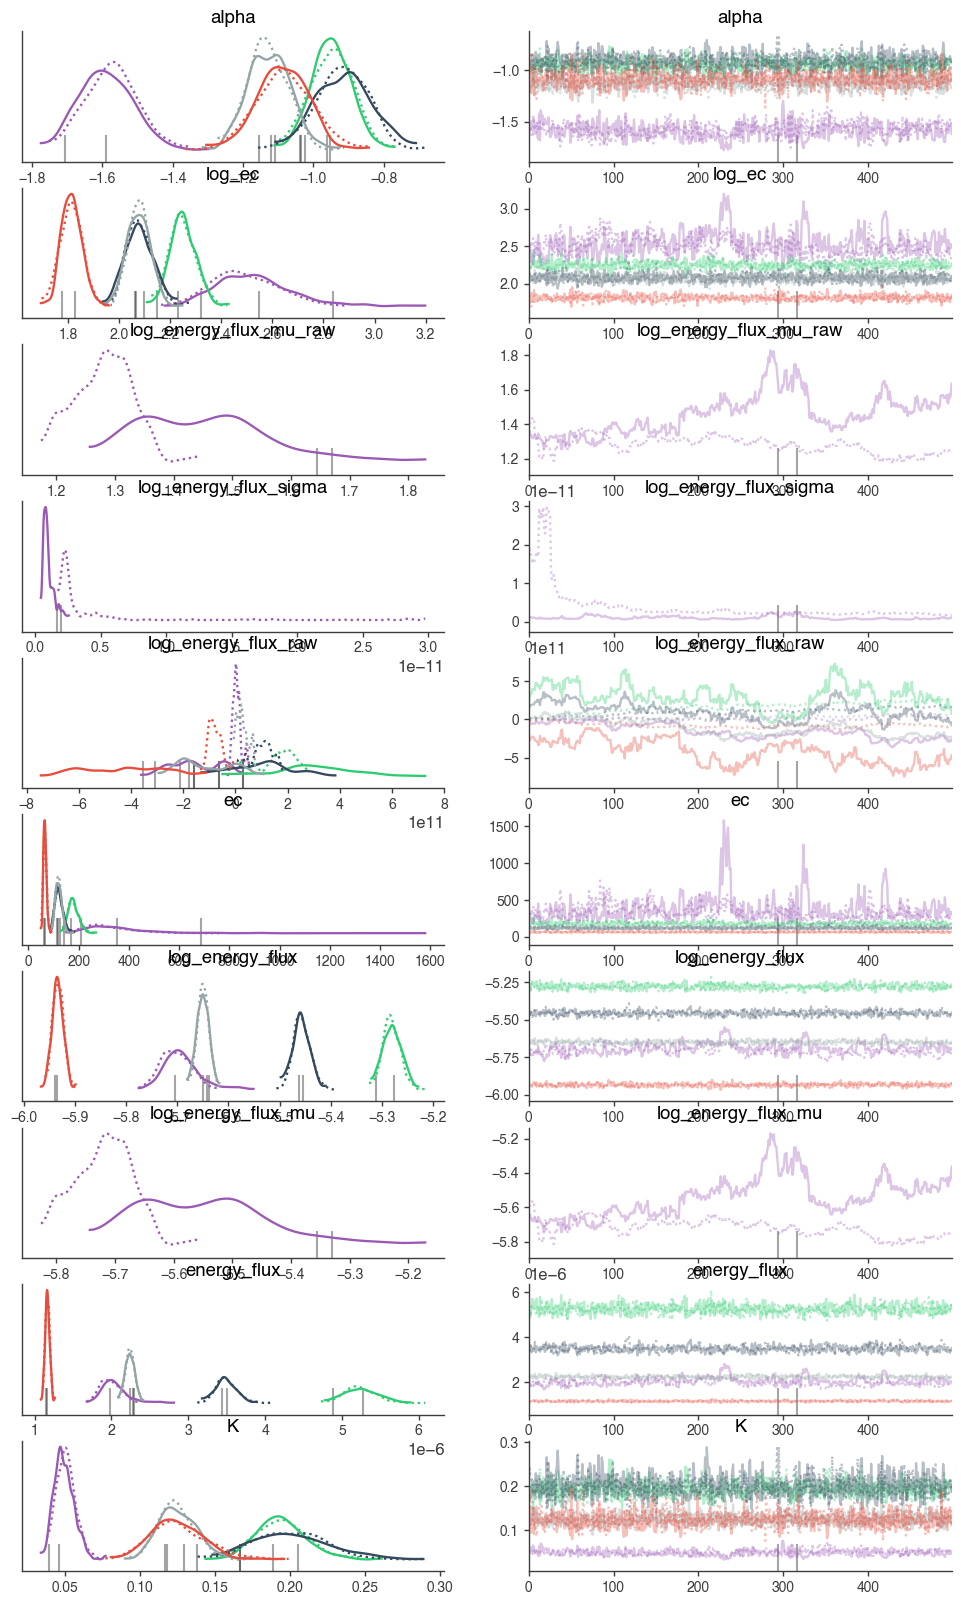

In [82]:
av.plot_trace(res)

In [53]:
bc = Band_Calderone(opt=0, a =10, b=1e4)
bc.beta.fix = True

In [54]:
id = 0

In [83]:
alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

ep = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**ep))


dl = ds.get_data_list_of_interval(id)

In [84]:
div.sum()

2

In [85]:
# bc = Band_Calderone(a=10.,b=1e4,opt=0)

# bc.beta.fix=True

bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
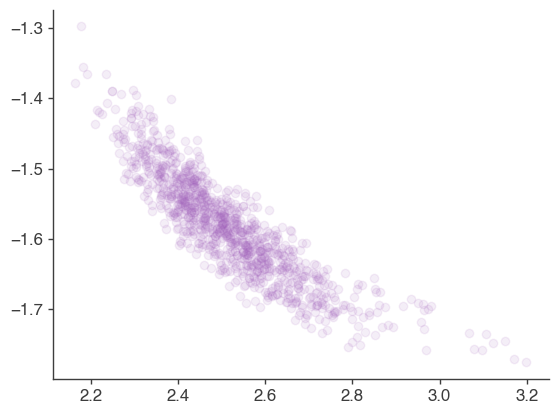

In [86]:
fig, ax = plt.subplots()


ax.scatter(ep, alpha, alpha=0.1)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
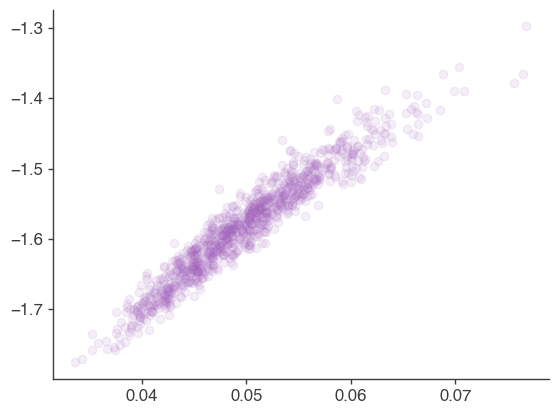

In [87]:
fig, ax = plt.subplots()


ax.scatter(K, alpha, alpha=0.1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
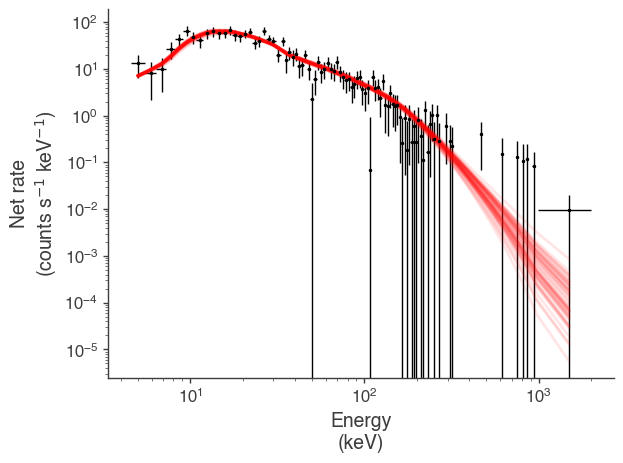

In [88]:
display_posterior_model_counts(dl[1],
                               model, 
                               samples.T[::20], 
                               min_rate=1e-99,
                               shade=False
                              
                              );

In [201]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)






dl = ds.get_data_list_of_interval(2)


model = Model(PointSource("ps",0,0, spectral_shape=cpl))


ba = JointLikelihood(model,DataList(*dl))

In [202]:
ba.fit();

Best fit values:



,result,unit
parameter,,
ps.spectrum.main.Cutoff_powerlaw.K,(2.29 -0.12 +0.13) x 10^-2,1 / (cm2 keV s)
ps.spectrum.main.Cutoff_powerlaw.index,-1.92 +/- 0.04,
ps.spectrum.main.Cutoff_powerlaw.xc,(0.7 -0.5 +2.6) x 10^4,keV



Correlation matrix:



1.00,0.88,-0.73
0.88,1.00,-0.66
-0.73,-0.66,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
b1,-28.217554
n0,67.683643
n1,78.156550
n5,65.671877
total,183.294516



Values of statistical measures:



,statistical measures
AIC,372.636275
BIC,385.304005


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
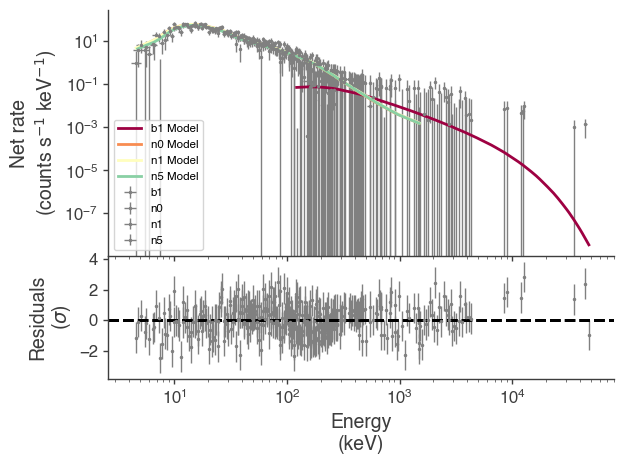

In [200]:
display_spectrum_model_counts(ba);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
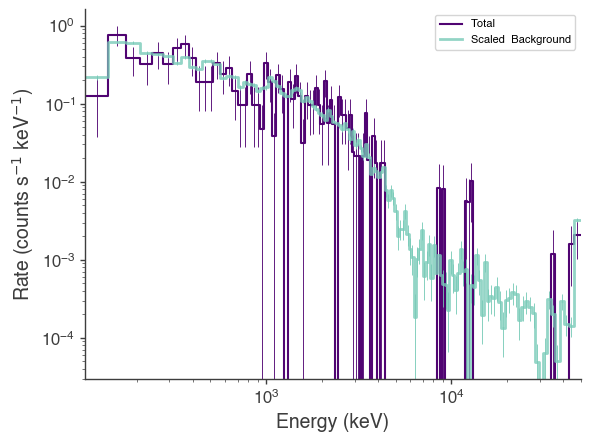

In [191]:
dl[0].view_count_spectrum();

In [24]:
cpl

* description: A power law multiplied by an exponential cutoff
  * formula: $ K~\frac{x}{piv}^{index}~\exp{-x/xc} $
  * parameters:
    * K:
      * value: 1.0
      * desc: Normalization (differential flux at the pivot value)
      * min_value: 1.0e-30
      * max_value: 1000.0
      * unit: ''
      * is_normalization: true
      * delta: 0.1
      * free: true
    * piv:
      * value: 100.0
      * desc: Pivot value
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: false
    * index:
      * value: -2.0
      * desc: Photon index
      * min_value: -10.0
      * max_value: 10.0
      * unit: ''
      * is_normalization: false
      * delta: 0.2
      * free: true
    * xc:
      * value: 10.0
      * desc: Cutoff energy
      * min_value: 1.0
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 1.0
      * free: true